# Observational Fairness on COMPAS Dataset
### Julia L. Wang

Reproducing: 

*   Dressel, Julia, and Hany Farid (2018). “The accuracy, fairness, and limits of predicting recidivism."

*   Wadsworth, Christina, Francesca Vera, and Chris Piech (2018). “Achieving fairness through adversarial learning: an application to recidivism prediction.”

Using the COMPAS dataset. 

In [1]:
# Initialization
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import chain

# COMPAS dataset
url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
df = pd.read_csv(url)

## Some Definitions

**Calibration:** positive predictive value (PPV) parity and negative predictive value (NPV) parity since the risk scores are 0/1 for not recidivate/ recidivate


*   PPV parity: P ( actually recidivate | model predicts recidivate) is equal for each demographic
*   NPV parity: P( actually recidivate | model predicts won't recidivate) is equal for each demographic



**False-positive parity:** P( model outputs recidivate | didn't actually recidivate) is equal regardless of demographic. 

##  Part 1: Logistic Regression Model

Reproducing Dressel et al. (2019) to predict 2-year recidivism. Dressel et al. split the data into 80% training and 20% testing, where they trained different models with various features. This section will replicate their training using 3 features, and test for false-positive parity and calibration between Caucasian and African-American demographics. 

In [182]:
## Encoding sex
encoded_sex = pd.Series(np.where(df.sex.values == 'Male', 1, 0), name="enc_sex")
newdf = pd.concat([df, encoded_sex], axis=1)

## Splitting the data into training and test sets
train, test = train_test_split(newdf, test_size=0.2, random_state=1500) #20% test size

## Training data we need- 2 features: age, priors_count
train_data = torch.tensor(train[["age", "priors_count", "enc_sex"]].to_numpy().astype(np.float32))
train_targets = torch.tensor(train[["two_year_recid"]].to_numpy().astype(np.float32))

## Test data for testing all demographics
test_data = torch.tensor(test[["age", "priors_count", "enc_sex"]].to_numpy().astype(np.float32))
test_targets = torch.tensor(test[["two_year_recid"]].to_numpy().astype(np.float32))

## Getting test data by race for comparison
caucasian = newdf[(newdf.race == "Caucasian")]
aa = newdf[(newdf.race == "African-American")]

# get caucasian and african-american data in the training set
aa_in_training = train.merge(aa, on=["id"])
caucasian_in_training = train.merge(caucasian, on=["id"])

# test sets: caucasian and aa not in the training set
aa_test = aa[~aa.id.isin(aa_in_training.id)]
caucasian_test = caucasian[~caucasian.id.isin(caucasian_in_training.id)]

## final data and targets for each demographic
cc_data = torch.tensor(caucasian_test[["age", "priors_count", "enc_sex"]].to_numpy().astype(np.float32))
cc_targets = torch.tensor(caucasian_test[["two_year_recid"]].to_numpy().astype(np.float32))

aa_data = torch.tensor(aa_test[["age", "priors_count", "enc_sex"]].to_numpy().astype(np.float32))
aa_targets = torch.tensor(aa_test[["two_year_recid"]].to_numpy().astype(np.float32))

# inputs into training logistic regression
x_train = train_data
y_train = train_targets

In [183]:
## Creating logistic regression model

class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
         
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

model = LogisticRegression(3, 1)

In [184]:
## Training the model

# set model parameters
criterion = torch.nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #Adam optimizer

# Training the model
for epoch in range(1000):
    y_pred = model(x_train) # get model output by inputting the training data
    loss = criterion(y_pred, y_train) # computing loss
    loss.backward()                   # Backward pass

    optimizer.step()
    optimizer.zero_grad()

    if (epoch+1)%100 == 0: # print the accuracy and loss for every 100 epochs
      model_out = torch.where(y_pred>0.50, 1, 0)
      truth = torch.sum(torch.eq(model_out, y_train).int())
      print("Model accuracy is ", truth/y_pred.shape[0], ". Loss is: ", loss.item())


Model accuracy is  tensor(0.6372) . Loss is:  0.6415098309516907
Model accuracy is  tensor(0.6449) . Loss is:  0.6280632615089417
Model accuracy is  tensor(0.6560) . Loss is:  0.6214768886566162
Model accuracy is  tensor(0.6652) . Loss is:  0.6190361380577087
Model accuracy is  tensor(0.6701) . Loss is:  0.6182019114494324
Model accuracy is  tensor(0.6737) . Loss is:  0.6178584694862366
Model accuracy is  tensor(0.6737) . Loss is:  0.6176652312278748
Model accuracy is  tensor(0.6749) . Loss is:  0.6175382733345032
Model accuracy is  tensor(0.6753) . Loss is:  0.6174543499946594
Model accuracy is  tensor(0.6744) . Loss is:  0.617401123046875


In [185]:
## Running the model on the test sets

caucasian_pred = model(cc_data) # caucasian test set
aa_pred = model(aa_data)        # african-american test set
overall_pred = model(test_data) # overall case with all demographics


### Calibration and False-Positive parity

In [2]:
def FalsePosRate(model_out, y_test):
  """
    model_out: models predictions of positive or negative (1/0)
    y_test: the ground truth values
    output: the false positive rate = # false positives / total true negatives
  """
  false_pos_count = 0
  total_neg_count = 0

  for i in range(len(model_out)):
    if y_test[i] == 0: # true  negative case
      total_neg_count+=1
      if model_out[i] != y_test[i]: #false pos when true negative & model predicts positive
        false_pos_count+=1
  # print("\tAmount of false positives:", false_pos_count)
  # print("\tAmount of negatives:", total_neg_count)

  return false_pos_count/total_neg_count

# print(FalsePosRate(model_out, y_test))

In [3]:
def Calibration(model_out, targets):
  """
    model_out: the models prediction of 0/1
    targets: the ground truth values
    outputs: PPV = P(ground truth = reoffend | model predicts reoffend)
            NPV = 1 - P(ground truth = reoffend | model predicts won't reoffend)
  """
  total_pos_count = 0
  total_neg_count = 0
  ppv_count = 0
  npv_count = 0

  for i in range(len(model_out)):
    if model_out[i] == 0: # model negative (reoffend)
      total_neg_count+=1
      if targets[i] ==1:  # true positive
        npv_count += 1
        
    else: # model positive case(reoffend)
      total_pos_count += 1
      if targets[i] == 1: # true positive
        ppv_count += 1
  
  PPV = ppv_count/total_pos_count
  NPV = 1-(npv_count/total_neg_count)

  return PPV, NPV

### Model calibration and FPV

In [188]:
## Showing that the model fails to satisfy false-positive parity

# Assigning model predictions to 0 or 1
caucasian_pred_thresholded = torch.where(caucasian_pred > 0.5, 1, 0)
aa_pred_thresholded = torch.where(aa_pred > 0.5, 1, 0)

# Calculating false positive rate for each demographic
caucasian_fpr = FalsePosRate(caucasian_pred_thresholded, cc_targets)
print("Caucasian false positive rate:", caucasian_fpr)

aa_fpr = FalsePosRate(aa_pred_thresholded, aa_targets)
print("African-American false positive rate:", aa_fpr)

## conclusion:
print("Difference between them is:", aa_fpr - caucasian_fpr)

#since the false positive rates were not the same between the 2, 
#there is no false positive parity

Caucasian false positive rate: 0.11610486891385768
African-American false positive rate: 0.2520107238605898
Difference between them is: 0.13590585494673213


In [189]:
## Showing that the model satisfies calibration

cc_ppv, cc_npv = Calibration(caucasian_pred_thresholded, cc_targets)
aa_ppv, aa_npv = Calibration(aa_pred_thresholded, aa_targets)

print("Caucasian PPV: ", cc_ppv, " African-American PPV: ", aa_ppv, "Difference = ", aa_ppv-cc_ppv)
print("Caucasian NPV: ", cc_npv, " African-American NPV: ", aa_npv, "Difference = ", aa_npv-cc_npv)


Caucasian PPV:  0.693069306930693  African-American PPV:  0.7359550561797753 Difference =  0.04288574924908228
Caucasian NPV:  0.6742857142857143  African-American NPV:  0.665871121718377 Difference =  -0.008414592567337231


### Comparing the differences in the demographics for false-positive parity and calibration

For the purposes of this lab, I will define a difference to be significant if it 5% or greater. Thus, it can be seen above that the model does not satisfy false-positive parity since the difference between the false positive rates (FPRs) is 13.6%. On the other hand, the differences between the PPVs and NPVs are 4.3% and 0.84% respectively, which are both under 5% and therefore can be concluded to display parity. Since having both PPV parity and NPV parity means that we have calibration, the model satisfies calibration.

### Base rates

In [190]:
caucasian = df[(df.race == "Caucasian")]
cc_recid = caucasian["two_year_recid"].to_numpy().astype(np.float32)

aa = df[(df.race == "African-American")]
aa_recid = aa["two_year_recid"].to_numpy().astype(np.float32)

print("African-american recidivism base rate:", np.sum(aa_recid)/aa.shape[0])
print("Caucasian recidivism base rate:", np.sum(cc_recid)/caucasian.shape[0])
print("Difference between base rates: ", np.sum(aa_recid)/aa.shape[0]-np.sum(cc_recid)/caucasian.shape[0])

African-american recidivism base rate: 0.5143398268398268
Caucasian recidivism base rate: 0.39364303178484106
Difference between base rates:  0.12069679505498576


The base rate for recidivism from the African-American demographic is higher than the Caucasian by 12.07%. False-positive parity occurs when people who did not reoffend are predicted to reoffend at the same rate. In this case, my model did not satisfy FFP with a 11.95% difference between false-positive rates, showing more false-positives for the African-American demographic. This is reflective of the base recidivism rate being higher since it causes the model to predict more recidivism for African-Americans.

### Adjusting thresholds

Text(0.5, 1.0, 'Effect of threshold on FPR')

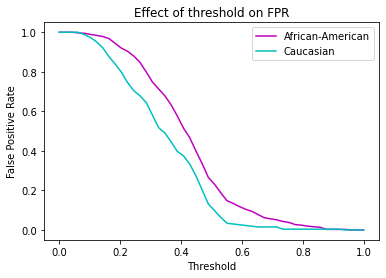

In [191]:
## Show adjusting thresholds satisfies false-positive parity 
thresholds = np.linspace(0, 1) # change threshold from 0 to 1 on the x-axis

# generate FPR rates for cc and aa
cc_fpr = []
aa_fpr = []

for i in thresholds:
  # taking each model output with different thresholds
  cc_thresholded = torch.where(caucasian_pred>i, 1, 0)
  aa_thresholded = torch.where(aa_pred>i, 1, 0)
  cc_fpr.append(FalsePosRate(cc_thresholded, cc_targets))
  aa_fpr.append(FalsePosRate(aa_thresholded, aa_targets))

# conversion to np array for plotting
cc_fpr = np.array(cc_fpr)
aa_fpr = np.array(aa_fpr)

# plotting
plt.plot(thresholds, aa_fpr, label = "African-American", color = "m")
plt.plot(thresholds, cc_fpr, label = "Caucasian", color= "c")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("False Positive Rate")
plt.title("Effect of threshold on FPR")


Plotting false positive rates with respect to different threshold values leads to the figure above. As such, it can be seen that a threshold of around 0.8 leads to false-positive parity where the rates for the demographics converge with less than 5% difference between them. Selecting this threshold, let's try to check the calibration.

In [192]:
## Show that thresholds satisfying false-positive parity doesn't satisfy calibration
caucasian_pred_thresholded = torch.where(caucasian_pred > 0.8, 1, 0)
aa_pred_thresholded = torch.where(aa_pred > 0.8, 1, 0)

cc_ppv, cc_npv = Calibration(caucasian_pred_thresholded, cc_targets)
aa_ppv, aa_npv = Calibration(aa_pred_thresholded, aa_targets)

print("For 0.8 Threshold:")
print("Caucasian PPV: ", cc_ppv, " African-American PPV: ", aa_ppv, "Difference = ", aa_ppv-cc_ppv)
print("Caucasian NPV: ", cc_npv, " African-American NPV: ", aa_npv, "Difference = ", aa_npv-cc_npv)

For 0.8 Threshold:
Caucasian PPV:  0.8888888888888888  African-American PPV:  0.8301886792452831 Difference =  -0.05870020964360578
Caucasian NPV:  0.6018099547511313  African-American NPV:  0.5041551246537397 Difference =  -0.09765483009739162


For the thresholds for which my model satisfied false-positive parity, the differences in PPV and NPV were significant (>5%), therefore, calibration is not satisfied after the threshold adjustment. 

Further statistical testing is required to conclude the significance of the differences between demographics for false-positive rates, PPV, and NPV. 

## Part 2: Adversial Learning Procedure

Reproducing Wadsworth et al. (2018) to produce more accurate classifier satisfying false-postiive partiy by introducing more features and using an adversial learning procedure.

In [4]:
# age, prior_count, sex, juv_misd_count, juv_other_count, juv_fel_count, c_charge_degree
# encoding some features into binary
encoded_sex = pd.Series(np.where(df.sex.values == 'Male', 1, 0), name="enc_sex")
encoded_charge_degree = pd.Series(np.where(df.c_charge_degree.values == 'F', 1, 0), name = "enc_charge_degree")
encoded_race = pd.Series(np.where(df.race.values == "Caucasian", 1, 0), name="enc_race")
newdf = pd.concat([df, encoded_sex, encoded_charge_degree, encoded_race], axis=1)

## Getting test data by race for comparison
caucasian = newdf[(newdf.race == "Caucasian")]
aa = newdf[(newdf.race == "African-American")]
newdf = pd.concat([caucasian, aa]) # dataframe now only consists of caucasian and aa

## Splitting the data into training and test sets
train, test = train_test_split(newdf, test_size=0.2, random_state=8) #20% test size

## Training data we need with 7 features
train_data = torch.tensor(train[["age", "priors_count", "enc_sex", "enc_charge_degree", "juv_misd_count", "juv_other_count", "juv_fel_count"]].to_numpy().astype(np.float32))
train_targets = torch.tensor(train[["two_year_recid"]].to_numpy().astype(np.float32))
train_targets2 = torch.tensor(train[["enc_race"]].to_numpy().astype(np.float32))

## Test data for testing all demographics
test_data = torch.tensor(test[["age", "priors_count", "enc_sex", "enc_charge_degree", "juv_misd_count", "juv_other_count", "juv_fel_count"]].to_numpy().astype(np.float32))
test_targets = torch.tensor(test[["two_year_recid"]].to_numpy().astype(np.float32))
test_targets2 = torch.tensor(test[["enc_race"]].to_numpy().astype(np.float32))

# get caucasian and african-american data in the training set
aa_in_training = train.merge(aa, on=["id"])
caucasian_in_training = train.merge(caucasian, on=["id"])

# test sets: caucasian and aa not in the training set
aa_test = aa[~aa.id.isin(aa_in_training.id)]
caucasian_test = caucasian[~caucasian.id.isin(caucasian_in_training.id)]

## final data and targets for each demographic
cc_data = torch.tensor(caucasian_test[["age", "priors_count", "enc_sex", "enc_charge_degree", "juv_misd_count", "juv_other_count", "juv_fel_count"]].to_numpy().astype(np.float32))
cc_targets = torch.tensor(caucasian_test[["two_year_recid"]].to_numpy().astype(np.float32))
cc_targets2 = torch.tensor(caucasian_test[["enc_race"]].to_numpy().astype(np.float32))

aa_data = torch.tensor(aa_test[["age", "priors_count", "enc_sex", "enc_charge_degree", "juv_misd_count", "juv_other_count", "juv_fel_count"]].to_numpy().astype(np.float32))
aa_targets = torch.tensor(aa_test[["two_year_recid"]].to_numpy().astype(np.float32))
aa_targets2 = torch.tensor(aa_test[["enc_race"]].to_numpy().astype(np.float32))

# inputs into training logistic regression
x_train = train_data
y_train = train_targets   # recidivism
y_train2 = train_targets2 # race

**Feature processing:** Features which were strings in the dataset were encoded into integer values- sex and crime degree were converted to binary 0 and 1s for the purposes of training the model. 

Wadsworth et al. (2018) used 10 features: charge degree, age, prior crimes, felonies, misdemeanors, days in jail, juvenile other, charges, juvenile misdemeanors, and jail history. To replicate this, I will be using features: age, sex, number of prior crimes, number of juvenile misdemeanors, number of juvinile felonies, and crime charge degree. 

### Creating and training models

 2 models: Wadsworth et al. implemented a predictor N and adversary A. I will be replicating the exact hyperparameters described in section 4 of Wadsworth et al. (2018). Adversary model 2 accepts a logit as an input, and adversary model 4 takes both the logit and the true recidivism. 

##### Model 1 and 2

Adversary accepts a logit as an input. 

In [310]:
## Predictor N Model
# 2 256-unit ReLU hidden layers
class Predictor(torch.nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()

        # fully connected layers
        self.fc1 = torch.nn.Linear(7, 256)   # 7 features from the dataset
        self.fc2 = torch.nn.Linear(256, 256) # 2x 256-unit ReLU 
        self.fc3 = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x)) # 2x 256-unit ReLU
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x 

## Adversary A Model
# 100 unit ReLU hidden layer
class Adversary(torch.nn.Module):
    def __init__(self):
        super(Adversary, self).__init__()

        self.fc1 = torch.nn.Linear(1, 100) # logit and true recidivism value
        self.fc2 = torch.nn.Linear(100, 1) # 100-unit ReLU

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) # sigmoid output
        return x

model1 = Predictor()
model2 = Adversary()

In [311]:
## Hyperparameters
# taken from section 4 of Wadsworth
alpha = 1
learning_rate = 1e-4 #np.exp(-4)
criterion = torch.nn.BCELoss(size_average=True) # binary cross entropy loss
optimizer_pred = torch.optim.Adam(model1.parameters(), lr= learning_rate) #Adam optimizer
optimizer_adv = torch.optim.Adam(model2.parameters(), lr = learning_rate)

### Adverserial learning procedure
# Following Figure 1 in Wadsworth

for epoch in range(800):

    ## zero out all gradients
    optimizer_pred.zero_grad() #2 optimizers for the 2 models
    optimizer_adv.zero_grad()

    ## forward pass
    pred_out = model1(x_train)   # input training data to model N
    y_pred = model2(pred_out)    # predictor output -> Adversary

    # computing adversary model loss, setting up for predictor
    adv_loss = criterion(pred_out, y_train) # computing adversary loss wrt recidivism
    pred_loss_p1 = criterion(y_pred, y_train2) # loss wrt race, to use in predictor loss

    ## backward pass and update adversary model
    adv_loss.backward(retain_graph=True) # retain graph: keeps all memory
    optimizer_adv.step() # update adversary model parameters
    optimizer_adv.zero_grad() # reset gradients to 0

    ## forward pass
    y_pred = model2(pred_out) # running adversary model again

    ## computing predictor model loss
    pred_loss_p1 = criterion(y_pred, y_train2) # loss wrt race, to use in predictor loss
    pred_loss = adv_loss - alpha*pred_loss_p1

    ## backward pass and updating predictor model parameters 
    pred_loss.backward()
    optimizer_pred.step()

    if (epoch+1)%50 == 0: # print the accuracy and loss for every 10 epochs
      model_out = torch.where(pred_out>0.50, 1, 0)
      truth = torch.sum(torch.eq(model_out, y_train).int())
      print("Model accuracy is ", truth/pred_out.shape[0], ". Loss is: ", pred_loss.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Model accuracy is  tensor(0.6425) . Loss is:  -0.07062077522277832
Model accuracy is  tensor(0.6549) . Loss is:  -0.07547938823699951
Model accuracy is  tensor(0.6675) . Loss is:  -0.07981103658676147
Model accuracy is  tensor(0.6701) . Loss is:  -0.08302432298660278
Model accuracy is  tensor(0.6715) . Loss is:  -0.08538031578063965
Model accuracy is  tensor(0.6738) . Loss is:  -0.08699804544448853
Model accuracy is  tensor(0.6722) . Loss is:  -0.08809536695480347
Model accuracy is  tensor(0.6738) . Loss is:  -0.0890931487083435
Model accuracy is  tensor(0.6740) . Loss is:  -0.08997434377670288
Model accuracy is  tensor(0.6748) . Loss is:  -0.09074163436889648
Model accuracy is  tensor(0.6750) . Loss is:  -0.09147030115127563
Model accuracy is  tensor(0.6752) . Loss is:  -0.09213745594024658
Model accuracy is  tensor(0.6748) . Loss is:  -0.0927889347076416
Model accuracy is  tensor(0.6752) . Loss is:  -0.09339451789855957
Model accuracy is  tensor(0.6754) . Loss is:  -0.093980908393859

##### Model 3 and 4

Adversary accepts a logit and the true recidivism value as inputs.

In [15]:
## Predictor N Model
# 2 256-unit ReLU hidden layers
torch.cuda.manual_seed_all(20220508)

class NewPredictor(torch.nn.Module):
    def __init__(self):
        super(NewPredictor, self).__init__()

        # fully connected layers
        self.fc1 = torch.nn.Linear(7, 256)   # 7 features from the dataset
        self.fc2 = torch.nn.Linear(256, 256) # 2x 256-unit ReLU 
        self.fc3 = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x)) # 2x 256-unit ReLU
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x, torch.sigmoid(x) ########## logit and recid now

## Adversary A Model
# 100 unit ReLU hidden layer
class NewAdversary(torch.nn.Module):
    def __init__(self):
        super(NewAdversary, self).__init__()

        self.fc1 = torch.nn.Linear(2, 100) ### taking in 2 now
        self.fc2 = torch.nn.Linear(100, 1) # 100-unit ReLU

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) # sigmoid output
        return x

model3 = NewPredictor()
model4 = NewAdversary()

In [16]:
## Hyperparameters
# taken from section 4 of Wadsworth
alpha2 = 1
learning_rate = 1e-4 #np.exp(-4)
criterion2 = torch.nn.BCELoss(size_average=True) # binary cross entropy loss
optimizer_pred2 = torch.optim.Adam(model3.parameters(), lr= learning_rate) #Adam optimizer
optimizer_adv2 = torch.optim.Adam(model4.parameters(), lr = learning_rate)

### Adverserial learning procedure
# Following Figure 1 in Wadsworth

for epoch in range(1000):

    ## zero out all gradients
    optimizer_pred2.zero_grad() #2 optimizers for the 2 models
    optimizer_adv2.zero_grad()

    ## forward pass
    pred_out2, recid = model3(x_train)   # input training data to model N
    y_pred2 = model4(torch.cat((pred_out2, y_train), axis=1))    # predictor output -> Adversary

    # computing adversary model loss, setting up for predictor
    adv_loss2 = criterion2(recid, y_train) # computing adversary loss wrt recidivism
    pred_loss_p12 = criterion2(y_pred2, y_train2) # loss wrt race, to use in predictor loss

    ## backward pass and update adversary model
    adv_loss2.backward(retain_graph=True) # retain graph: keeps all memory
    optimizer_adv2.step() # update adversary model parameters
    optimizer_adv2.zero_grad() # reset gradients to 0

    ## forward pass
    y_pred2 = model4(torch.cat((pred_out2, y_train), axis=1)) # running adversary model again

    ## computing predictor model loss
    pred_loss_p12 = criterion2(y_pred2, y_train2) # loss wrt race, to use in predictor loss
    pred_loss2 = adv_loss2 - alpha2*pred_loss_p12

    ## backward pass and updating predictor model parameters 
    pred_loss2.backward()
    optimizer_pred2.step()

    if (epoch+1)%100 == 0: # print the accuracy and loss for every 10 epochs
      model_out = torch.where(pred_out2>0.50, 1, 0)
      truth = torch.sum(torch.eq(model_out, y_train).int())
      print("Model accuracy is ", truth/pred_out2.shape[0], ". Loss is: ", pred_loss2.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Model accuracy is  tensor(0.6211) . Loss is:  -0.11677652597427368
Model accuracy is  tensor(0.6390) . Loss is:  -0.12302696704864502
Model accuracy is  tensor(0.6482) . Loss is:  -0.12514859437942505
Model accuracy is  tensor(0.6520) . Loss is:  -0.1263914704322815
Model accuracy is  tensor(0.6541) . Loss is:  -0.12772786617279053
Model accuracy is  tensor(0.6571) . Loss is:  -0.12930864095687866
Model accuracy is  tensor(0.6581) . Loss is:  -0.13128221035003662
Model accuracy is  tensor(0.6571) . Loss is:  -0.1333962082862854
Model accuracy is  tensor(0.6581) . Loss is:  -0.13560175895690918
Model accuracy is  tensor(0.6587) . Loss is:  -0.13804370164871216


Similar to the results demonstrated by Wadsworth et al., the model (4) accepting both logit and true recidivism performed around the same compared to the model (2) which accepted the logit. Both accuracies converged to around 67%. Therefore, second model (4) was used for the rest of the lab. 

### Testing

Continuing with model1 and 2: testing FPR and calibration.

In [17]:
log1, caucasian_pred = model3(cc_data) # caucasian test set
log2, aa_pred = model3(aa_data)       # african-american test set
log3, overall_pred = model3(test_data) # overall case with all demographics

Text(0.5, 1.0, 'Effect of threshold on FPR')

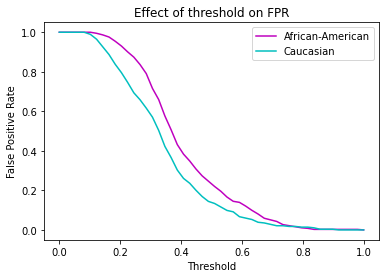

In [342]:
## False positive parity for different thresholds

thresholds = np.linspace(0, 1) # change threshold from 0 to 1 on the x-axis
# generate FPR rates for cc and aa
cc_fpr = []
aa_fpr = []

for i in thresholds:
  # taking each model output with different thresholds
  cc_thresholded = torch.where(caucasian_pred>i, 1, 0)
  aa_thresholded = torch.where(aa_pred>i, 1, 0)
  cc_fpr.append(FalsePosRate(cc_thresholded, cc_targets))
  aa_fpr.append(FalsePosRate(aa_thresholded, aa_targets))

# conversion to np array for plotting
cc_fpr = np.array(cc_fpr)
aa_fpr = np.array(aa_fpr)

# plotting
plt.plot(thresholds, aa_fpr, label = "African-American", color = "m")
plt.plot(thresholds, cc_fpr, label = "Caucasian", color= "c")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("False Positive Rate")
plt.title("Effect of threshold on FPR")

It appears that the false-positive disparity is smaller using Wadsworth et al.'s method. As shown in the figure above and knowing the false-positive disparity is the difference between the 2 curves, the results from this adversarial model have less false-positive disparity compared to the logistic. This is because the lines representing the different demographics are observed to be closer together, therefore, demonstrating false-positive parity as the differences between them average under 5%.

In [18]:
## Show that thresholds satisfying calibration is also satisfied
# using the same threshold used in part 1 (this enables us to compare the 2 results)

caucasian_pred_thresholded = torch.where(caucasian_pred > 0.5, 1, 0)
aa_pred_thresholded = torch.where(aa_pred > 0.5, 1, 0)

cc_ppv, cc_npv = Calibration(caucasian_pred_thresholded, cc_targets)
aa_ppv, aa_npv = Calibration(aa_pred_thresholded, aa_targets)

print("For 0.5 Threshold:")
print("Caucasian PPV: ", cc_ppv, " African-American PPV: ", aa_ppv, "Difference = ", aa_ppv-cc_ppv)
print("Caucasian NPV: ", cc_npv, " African-American NPV: ", aa_npv, "Difference = ", aa_npv-cc_npv)

For 0.5 Threshold:
Caucasian PPV:  0.6515151515151515  African-American PPV:  0.6951566951566952 Difference =  0.04364154364154371
Caucasian NPV:  0.6799999999999999  African-American NPV:  0.6700251889168766 Difference =  -0.00997481108312337


From this result, it can be seen that calibration is also satisfied with differences in PPV and NPV of 4.36% and 1% respectively. 

In [20]:
## getting the false positive rate for threshold 0.8 to compare with logistic model

cc_th = torch.where(caucasian_pred>0.8, 1, 0)
aa_th = torch.where(aa_pred>0.8, 1, 0)

cc_fpr = (FalsePosRate(cc_th, cc_targets))
aa_fpr = (FalsePosRate(aa_th, aa_targets))
print("The false-positive disparity for threshold 0.8 is: ", aa_fpr-cc_fpr)

The false-positive disparity for threshold 0.8 is:  0.0065230525242608445


## Overview
**Features**: The features used to train the adversarial model were age, sex, number of prior crimes, number of juvenile misdemeanors, number of juvinile felonies, and crime charge degree. Features which were strings in the dataset were encoded into integer values- sex and crime degree were converted to binary 0 and 1s for the purposes of training the model.

**Comparison to Wadsworth**

*Model:*
As summarized earlier, it was found that training a model with just a logit as an input to the adversary was similar in range to the logit and recidivism value. The final model is as follows: The Predictor takes the 7 features from the dataset, put them through 2 256 unit ReLU fully-connected layers, then outputs both logit and recidivism value. The Adversary model takes the output from the predictor and passes it through an 100-unit ReLU layer. All hyperparameters were used following the description in Wadsworth et al. Section 4- binary cross-entropy loss, alpha = 1, adam optimizer, and sigmoid output layer.

*Classifier Accuracy of Wadsworth et al:*
Using the same threshold of 0.8 to compare results from Part 1 and Part 2 (Wadsworth), the adversarial network proposed by Wadsworth et al. performs considerably better with less false-positive predictions and satisfied calibration. This was demonstrated above where Wadsworth's model trained with 7 features has a small false-positive disparity of 0.65%, and how the differences in NPV and PPV were minimal at 4% and 1% respectively. In part 1 where 3 features were used, the same threshold revealed false-positive parity and not calibration through NPV and PPV values of 6% and 9%. Therefore,  Wadsworth's network utilizing more features yielded a more accurate classifier.


*False-positive disparity:* To observe the false-positive disparity, the false positive rates for each model was plotted against potential thresholds. Comparing these figures in Part 1 and Part 2, the false-positive rates are closer together using the network proposed by Wadsworth et al., thus, exhibit false-positive parity better.

**Further Steps**

More testing is required to demonstrate the decrease in false-positive disparity using Wadsworth's model. One potential future step is to plot the difference between FPRs, comparing between each model. Similarly, calibration could be calculated for each threshold to gain an overall sense. Statistical testing also could be implenented to determine the significance of each value, rather than assuming that values over 5% are significant.